In [1]:
# Imports
import os
import sys
import torch.cuda, torch.utils.data, torch.nn, torch.optim, torch
import torchvision.transforms, torchvision.datasets.folder, torchvision.utils
from sklearn.cluster import KMeans
from cv2 import imread as img_read
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import math

!pip install einops
sys.path.append('kaggle/input/clevertex/part2/part2')
sys.path.append(os.path.abspath('../input/clevertex/part2/part2'))
from vae_ import VAE

In [2]:
# Addresses

class Address:
    def __init__(self):
        '''
        Stores all the addresses used in project
        '''
        # Inputs
        self.data = "../input/clevertex/dataset/dataset"
        self.img_train = os.path.join(self.data, "images/train")
        self.img_val = os.path.join(self.data, "images/val")
        self.mask_train = os.path.join(self.data, "masks/train")
        self.mask_val = os.path.join(self.data, "masks/val")

        # Models
        self.model = "results/"
        self.slot_attention = os.path.join(self.model, "slot_attention")
        self.vae_checkpoint = "../input/clevertex/part2/part2/vae_checkpoint.pth"
        self.slot_diffusion = os.path.join(self.model, "slot_diffusion")
        self.diff_checkpoint = "../input/clevertex/best2.pth"
        self.slot_checkpoint = "../input/clevertex/best1.pth"

        # Temp
        self.temp = "temp/"

    def create_dir(self, dir_list = None):
        '''
        Function to create directories in dir_list. If dir_list is None then create all directories of address.
        '''
        if dir_list == None:
            dir_list = [self.model, self.temp, self.slot_attention, self.slot_diffusion]
        for address in dir_list:
            if not os.path.exists(address):
                os.mkdir(address)

    def _delete_folder_content(self, folder_addr):
        '''
        Deletes all the content of folder_addr
        '''
        if os.path.exists(folder_addr):
            for file in os.listdir(folder_addr):
                address = os.path.join(folder_addr, file)
                if os.path.isdir(address):
                    self._delete_folder_content(address)
                    os.removedirs(address)
                else:
                    os.remove(address)

    def clean(self, file_list = None):
        '''
        Deletes all the content in file_list
        '''
        if file_list == None:
            file_list = [self.temp]
        for address in file_list:
            self._delete_folder_content(address)

addr = Address()
addr.clean()
# addr.clean([addr.slot_attention])
addr.create_dir()

In [3]:
class HyperParameters:
    def __init__(self):
        '''
        Stores all Hyperparameters used for training of model
        '''
        # Training
        self.batch_size = 8
        self.resolution = (128, 128)
        self.num_epoch = 30
        self.grad_clip = 1.0

        # Data
        self.num_train = 40000
        self.num_val = 10000
        self.train_step = self.num_epoch*(self.num_train//self.batch_size)
        
        # Learning Rate
        self.lr = 2e-4
        self.slot_lr = 2e-4
        self.warmup_step = self.train_step//40
        self.decay_step = self.train_step//2
        self.decay_rate = 0.5

        # Encoder
        self.dim_input = 64
        self.shift = 3
        self.num_resblock = 1

        # Slot Attention
        self.dim_slot = 64
        self.dim_projected = 64
        self.dim_mlp_slot = 128
        self.num_slot = 11
        self.num_iter_slot = 3
        self.epsilon = 1e-8

        # Decoder
        self.decoder_channel = 64

        # Evaluation
        self.ari_batch_size = 32

        # Diffusion
        self.diffusion_time = 1000
        self.beta1 = 0.0015
        self.betaT = 0.0195
        self.dim_time = 128
        self.num_channel = 64
        self.num_repeat = 6
        self.dim_head = 32

    def lr_schedule(self, step):
        '''
        Getting learning rate as function of train steps completed
        '''
        if step <= self.warmup_step:
            return step/self.warmup_step
        else:
            return self.decay_rate**((step-self.warmup_step)/self.decay_step)

    def create_report(self, addr):
        with open(os.path.join(addr, 'param.txt'), 'w') as file:
            file.writelines([
                f'Training:',
                f'\n\tBatch Size:       {self.batch_size}',
                f'\n\tResolution:       {self.resolution}',
                f'\n\tNum Epoch:        {self.num_epoch}',
                f'\n\tGrad Clip:        {self.grad_clip}',
                f'\n\nData:',  
                f'\n\tNum Train:        {self.num_train}',
                f'\n\tNum Val:          {self.num_val}',
                f'\n\tTrain Step:       {self.train_step}',
                f'\n\nLearning Rate:',  
                f'\n\tlr:               {self.lr}',
                f'\n\tslot_lr:          {self.slot_lr}',
                f'\n\tWarmup Step:      {self.warmup_step}',
                f'\n\tDecay Step:       {self.decay_step}',
                f'\n\tDecay Rate:       {self.decay_rate}',
                f'\n\nEncoder:',  
                f'\n\tDim Input:        {self.dim_input}',
                f'\n\tShift:            {self.shift}',
                f'\n\tNum Resblock:     {self.num_resblock}',
                f'\n\nSlot Attention:',
                f'\n\tDim Slot:         {self.dim_slot}',
                f'\n\tDim Projected:    {self.dim_projected}',
                f'\n\tDim MLP slot:     {self.dim_mlp_slot}',
                f'\n\tNum Slot:         {self.num_slot}',
                f'\n\tNum Iter Slot:    {self.num_iter_slot}',
                f'\n\tEpsilon:          {self.epsilon}',
                f'\n\nDecoder:',  
                f'\n\tDecoder Channel:  {self.decoder_channel}',
                f'\n\nEvaluation:',
                f'\n\tARI Batch Size:   {self.ari_batch_size}',
                f'\n\nDiffusion:',
                f'\n\tDiffusion Time:   {self.diffusion_time}',
                f'\n\tBeta_1:           {self.beta1}',
                f'\n\tBeta_T:           {self.betaT}',
                f'\n\tDim Time:         {self.dim_time}',
                f'\n\tNum Channel:      {self.num_channel}',
                f'\n\tNum Repeat:       {self.num_repeat}',
                f'\n\tDim Head:         {self.dim_head}'
            ])

param = HyperParameters()

In [4]:
# Random Seed and CUDA

random_seed = 68
device = "cpu"
torch.manual_seed(random_seed)
np.random.seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
    device = "cuda"
print(f"Working with device {device}")

Working with device cuda


In [5]:
# Dataset

class DataSet(torch.utils.data.Dataset):
    def __init__(self, resolution, address_img, address_mask = None):
        self.address_img = address_img
        self.address_mask = address_mask
        self.img_list = sorted(os.listdir(self.address_img))
        if self.address_mask is not None:
            self.mask_list = sorted(os.listdir(self.address_mask))
            self.mask_dict = {(0, 0, 0): 0}
            self.num_category = 1
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Resize(resolution, antialias=False)])

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_addr = os.path.join(self.address_img, self.img_list[idx])
        img = torchvision.datasets.folder.default_loader(img_addr)

        if self.address_mask is not None:
            mask_addr = os.path.join(self.address_mask, self.mask_list[idx])
            mask = img_read(mask_addr)
            new_mask = torch.zeros(mask.shape[0], mask.shape[1], dtype=torch.long)
            for i in range(mask.shape[0]):
                for j in range(mask.shape[1]):
                    color = tuple(mask[i, j, :])
                    if color not in self.mask_dict:
                        self.mask_dict[color] = self.num_category
                        self.num_category += 1
                    new_mask[i,j] = self.mask_dict[color]

            return {
                'img': self.transform(img).to(torch.float),
                'mask': new_mask
            }
        
        return self.transform(img).to(torch.float)

class Data:
    def __init__(self, address: Address, param: HyperParameters, device = device):
        '''
        Creates DataLoader and DataSet for both train and val split
        '''
        self.address = address
        self.device = device

        # Dataset for training
        self.dataset_train_without_mask = DataSet(param.resolution, address.img_train)
        self.dataset_val_without_mask = DataSet(param.resolution, address.img_val)

        # DataLoader for training
        self.loader_train_without_mask = torch.utils.data.DataLoader(self.dataset_train_without_mask,
                                                                     batch_size=param.batch_size,
                                                                     shuffle=True)
        self.loader_val_without_mask = torch.utils.data.DataLoader(self.dataset_val_without_mask,
                                                                   batch_size=param.batch_size,
                                                                   shuffle=False)

        # Dataset for evaluation
        self.dataset_train_with_mask = DataSet(param.resolution, address.img_train, address.mask_train)
        self.dataset_val_with_mask = DataSet(param.resolution, address.img_val, address.mask_val)

        # DataLoader for evaluation
        self.loader_train_with_mask = torch.utils.data.DataLoader(self.dataset_train_with_mask,
                                                                  batch_size=param.ari_batch_size,
                                                                  shuffle=False,
                                                                  collate_fn=self.collate,
                                                                  num_workers=4)
        self.loader_val_with_mask = torch.utils.data.DataLoader(self.dataset_val_with_mask,
                                                                batch_size=param.ari_batch_size,
                                                                shuffle=False,
                                                                collate_fn=self.collate)

    def collate(self, batch):
        img = [elem['img'] for elem in batch]
        mask = [elem['mask'] for elem in batch]

        return {
            'img': torch.stack(img),
            'mask': torch.stack(mask)
        }

data = Data(addr, param)

In [6]:
# Models

def create_grid(resolution):
    '''
    Creates the grid of size resolution with 4 channels. Each channel representing gradient in [0, 1] for one of the four direction.
    '''
    x_grad = np.linspace(0, 1, resolution[1])
    y_grad = np.linspace(0, 1, resolution[0])
    grid = np.meshgrid(y_grad, x_grad, indexing='ij')
    grid = np.stack(grid, axis = -1)
    grid = np.concatenate([grid, 1-grid], axis=-1)
    grid = np.expand_dims(grid, axis=0)
    return torch.tensor(grid, dtype=torch.float, requires_grad=False)

class ResBlock(torch.nn.Module):
    def __init__(self, num_channel, kernel_size=5, stride=1, padding='same'):
        '''
        Initializes a Resnet Block with one convolution layer having ReLU activation
        '''
        super(ResBlock, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(num_channel, num_channel, kernel_size, stride=stride, padding=padding, dtype=torch.float)
        self.norm1 = torch.nn.InstanceNorm2d(num_channel)
        self.activation1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(num_channel, num_channel, kernel_size, stride=1, padding='same', dtype=torch.float)
        self.norm2 = torch.nn.InstanceNorm2d(num_channel)
        self.activation2 = torch.nn.ReLU()

        self.project = True if (stride != 1) else False
        if self.project:
            self.conv_project = torch.nn.Conv2d(num_channel, num_channel, kernel_size, stride=stride, padding=padding, dtype=torch.float)

    def forward(self, x):
        res = x

        # First convolution
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.activation1(x)

        # Second Convolution
        x = self.conv2(x)
        x = self.norm2(x)
        x = x + (self.conv_project(res) if self.project else res)
        x = self.activation2(x)
        return x

class Encoder(torch.nn.Module):
    def __init__(self, num_channel, shift, num_resblock=1, device=device):
        '''
        Encodes input image into feature vectors
        '''
        super(Encoder, self).__init__()

        self.device = device
        self.num_channel = num_channel
        self.shift = shift

        # CNN backbone of Encoder    
        cnn = [torch.nn.Conv2d(3, num_channel, 5, stride=1, padding='same', dtype=torch.float), torch.nn.ReLU()]
        for _ in range(shift):
            cnn.append(ResBlock(num_channel, 5, stride=2, padding=2))
            for i in range(num_resblock):
                cnn.append(ResBlock(num_channel, 5, stride=1, padding='same'))
        cnn.append(ResBlock(num_channel, 5, stride=1, padding='same'))
        self.cnn = torch.nn.Sequential(*cnn)
        
        # Positional Embedding
        self.register_buffer('grid', None)
        self.embed = torch.nn.Linear(4, num_channel, dtype=torch.float)

        # Flatten
        self.flatten = torch.nn.Flatten(start_dim=1, end_dim=2)

        # Layer Norm
        self.layer_norm = torch.nn.LayerNorm(num_channel, dtype=torch.float)

        # MLP
        self.mlp = torch.nn.Sequential(torch.nn.Linear(num_channel, num_channel, dtype=torch.float),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(num_channel, num_channel, dtype=torch.float))

    def forward(self, x: torch.Tensor):
        x = self.cnn(x)     # CNN

        x = x.permute((0, 2, 3, 1))     # Permuting Channel axis at the end

        if self.grid is None:
            self.grid = create_grid(x.shape[1:3]).to(self.device)
        x = x + self.embed(self.grid)   # Positional Embedding

        x = self.flatten(x)     # Flatten into feature vector

        x = self.layer_norm(x)  # Layer Normalization

        x = self.mlp(x)     # MLP

        return x

class SlotAttention(torch.nn.Module):
    def __init__(self, dim_input, dim_slot, dim_projected, dim_mlp, num_slot, num_iter, epsilon, device=device):
        '''
        Implementes Slot Attention
        '''
        super(SlotAttention, self).__init__()

        self.device = device
        self.dim_input = dim_input
        self.dim_slot = dim_slot
        self.dim_projected = dim_projected
        self.dim_mlp = dim_mlp
        self.num_slot = num_slot
        self.num_iter = num_iter
        self.epsilon = epsilon

        # Layer Norm
        self.layer_norm_inp = torch.nn.LayerNorm(dim_input, dtype=torch.float)
        self.layer_norm_slot = torch.nn.LayerNorm(dim_slot, dtype=torch.float)

        # Slot Initialization Parameters
        self.slots = torch.nn.Parameter(torch.randn(1, self.num_slot, self.dim_slot, dtype=torch.float))
        # self.mean_slot = torch.nn.Parameter(torch.zeros(1, 1, self.dim_slot, dtype=torch.float))
        # self.log_std_slot = torch.nn.Parameter(torch.zeros(1, 1, self.dim_slot, dtype=torch.float))
        # torch.nn.init.xavier_uniform_(self.mean_slot)
        # torch.nn.init.xavier_uniform_(self.log_std_slot)

        # Projection matrix
        self.project_key = torch.nn.Linear(self.dim_input, self.dim_projected, bias=False, dtype=torch.float)
        self.project_value = torch.nn.Linear(self.dim_input, self.dim_projected, bias=False, dtype=torch.float)
        self.project_query = torch.nn.Linear(self.dim_slot, self.dim_projected, bias=False, dtype=torch.float)

        # Slot update
        self.gru = torch.nn.GRUCell(self.dim_projected, self.dim_slot)
        self.mlp = torch.nn.Sequential(torch.nn.Linear(self.dim_slot, self.dim_mlp),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(self.dim_mlp, self.dim_slot))

    def forward(self, x, ret_attn = False):
        x = self.layer_norm_inp(x)          # Layer Normalization

        slots = torch.tile(self.slots, dims = (x.shape[0], 1, 1))                  # Initializing Slot
        # slots = self.mean_slot + torch.exp(self.log_std_slot)*torch.randn((x.shape[0], self.num_slot, self.dim_slot), device=self.device)      # Initializing slot
        attn_arr = []

        for t in range(self.num_iter):
            slots_prev = slots
            slots = self.layer_norm_slot(slots)         # Layer Normalization

            # Computing Attention
            attn = torch.matmul(self.project_key(x), self.project_query(slots).permute(0, 2, 1))   # Dot product of key and query
            attn /= np.sqrt(self.dim_projected)                                                    # Setting SoftMax temperature
            attn = torch.nn.functional.softmax(attn, dim=-1) + self.epsilon                        # Softmax with numerical stability
            attn_arr.append(attn)

            # Updating Slot
            weights = attn/torch.sum(attn, dim=1, keepdim=True)                         # Calculating weights for update
            updates = torch.bmm(weights.permute(0, 2, 1), self.project_value(x))        # Update array
            slots = self.gru(updates.reshape(-1, self.dim_projected), slots_prev.reshape(-1, self.dim_slot))    # GRU update
            slots = slots.reshape(-1, self.num_slot, self.dim_slot)
            slots = slots + self.mlp(slots)                                                    # Residual MLP update
        
        if ret_attn:
            return slots, torch.stack(attn_arr).permute(1, 0, 2, 3)
        return slots

class SBDecoder(torch.nn.Module):
    def __init__(self, num_slot, dim_slot, resolution, num_channel, device=device):
        '''
        Implements Spatial Broadcast Decoder
        '''
        super(SBDecoder, self).__init__()

        self.device = device
        self.num_slot = num_slot
        self.dim_slot = dim_slot
        self.resolution = resolution
        self.num_channel = num_channel

        # Grid for spatial feature
        self.register_buffer('grid', 2*create_grid(resolution).permute(0, 3, 1, 2)[:, :2, :, :]-1)

        # CNN Decoder
        self.cnn = torch.nn.Sequential(torch.nn.Conv2d(2+dim_slot, num_channel, 5, stride=1, padding='same', dtype=torch.float),
                                       torch.nn.ReLU(),
                                       torch.nn.Conv2d(num_channel, num_channel, 5, stride=1, padding='same', dtype=torch.float),
                                       torch.nn.ReLU(),
                                       torch.nn.Conv2d(num_channel, 4, 5, stride=1, padding='same', dtype=torch.float))

    def forward(self, slots):
        x = slots.reshape((-1, self.dim_slot, 1, 1))
        
        # Creating tiled latents
        x = torch.tile(x, (1, 1, self.resolution[0], self.resolution[1]))
        x = torch.concat([x, torch.tile(self.grid, (x.shape[0], 1, 1, 1))], dim=1)

        # Decoding
        x = self.cnn(x)

        # Unstack and Split
        x = x.reshape(-1, self.num_slot, 4, self.resolution[0], self.resolution[1])
        img, mask = torch.split(x, [3, 1], dim=2)

        # Reconstructing Image
        mask = torch.nn.functional.softmax(mask, dim=1)
        recon_img = torch.sum(img*mask, dim=1)
        
        return recon_img, img, mask.squeeze(2), slots

class ObjectDiscovery(torch.nn.Module):
    def __init__(self, param: HyperParameters, device=device):
        '''
        Architecture enclosing encoder, slot attention, spatial broadcast decoder for object discovery task
        '''
        super(ObjectDiscovery, self).__init__()

        self.device = device
        self.encoder = Encoder(param.dim_input, param.shift, device=device)
        self.slot_attention = SlotAttention(param.dim_input,
                                            param.dim_slot,
                                            param.dim_projected,
                                            param.dim_mlp_slot,
                                            param.num_slot,
                                            param.num_iter_slot,
                                            param.epsilon,
                                            device=device)
        self.decoder = SBDecoder(param.num_slot,
                                 param.dim_slot,
                                 param.resolution,
                                 param.decoder_channel,
                                 device=device)
    
    def forward(self, x, slot_only = False, attn=False):
        x = self.encoder(x)
        if attn:
            x, attn_map = self.slot_attention(x, ret_attn = True)
            return attn_map
        x = self.slot_attention(x)
        if slot_only:
            return x
        return self.decoder(x)

class ResBlockUNET(torch.nn.Module):
    def __init__(self, in_channel, out_channel, dim_time, mode, kernel_size = 5, num_grp = 4):
        super(ResBlockUNET, self).__init__()

        self.mode = mode

        # Block corresponding to input for various uses of res block
        if mode == 'down':
            self.inp = torch.nn.Sequential(
                torch.nn.GroupNorm(num_grp, in_channel),
                torch.nn.SiLU(),
                torch.nn.AvgPool2d(2, 2)
            )
        elif mode == 'up':
            self.inp = torch.nn.Sequential(
                torch.nn.GroupNorm(num_grp, in_channel),
                torch.nn.SiLU()
            )
        elif mode == 'same':
            self.inp = torch.nn.Sequential(
                torch.nn.GroupNorm(num_grp, in_channel),
                torch.nn.SiLU(),
                torch.nn.Conv2d(in_channel, in_channel, kernel_size, padding='same')
            )
        else:
            raise Exception("No such mode")

        # Transforming time embedding to channel dimension
        self.time = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(dim_time, in_channel)
        )

        # Layer for output generation with shortcut connection
        self.out = torch.nn.Sequential(
            torch.nn.GroupNorm(num_grp, in_channel),
            torch.nn.SiLU(),
            torch.nn.Dropout(),
            torch.nn.Conv2d(in_channel, out_channel, kernel_size, padding='same')
        )

        self.project = None
        if in_channel != out_channel:
            self.project = torch.nn.Conv2d(in_channel, out_channel, kernel_size, padding='same')

    def forward(self, inp, time_emb):
        inp_processed = self.inp(inp)
        if self.mode == 'up':
            inp_processed = torch.nn.functional.interpolate(inp_processed, scale_factor=2)
        time_processed = self.time(time_emb).unsqueeze(-1).unsqueeze(-1)
        x = inp_processed + time_processed
        if self.project is None:
            out = x + self.out(x)
        else:
            out = self.project(x) + self.out(x)
        return out

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, dim_x, dim_query, dim_attention, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.dim_attention = dim_attention
        self.num_head = num_heads
        self.query = torch.nn.Linear(dim_query, dim_attention, bias=False)
        self.attention = torch.nn.MultiheadAttention(dim_attention, num_heads, kdim=dim_x, vdim=dim_x)
    
    def forward(self, x, query):
        return self.attention.forward(self.query(query), x, x, need_weights=False)[0]

class TransformerBlock(torch.nn.Module):
    def __init__(self, num_repeat, dim_head, dim_slot, in_channel, device=device, num_grp = 4):
        super(TransformerBlock, self).__init__()

        self.num_repeat = num_repeat
        self.dim_head = dim_head
        self.in_channel = in_channel
        self.dim_slot = dim_slot
        self.device = device

        self.norm1 = torch.nn.GroupNorm(num_grp, in_channel)
        self.conv1 = torch.nn.Conv2d(in_channel, in_channel, 1)

        self.self_attention = torch.nn.ModuleList([torch.nn.MultiheadAttention(in_channel, in_channel//dim_head, batch_first=True) for i in range(num_repeat)])
        self.norm2 = torch.nn.ModuleList([torch.nn.LayerNorm(self.in_channel) for i in range(num_repeat)])

        self.cross_attention = torch.nn.ModuleList([torch.nn.MultiheadAttention(in_channel, in_channel//dim_head, kdim=dim_slot, vdim=dim_slot, batch_first=True) for i in range(num_repeat)])
        self.norm3 = torch.nn.ModuleList([torch.nn.LayerNorm(self.in_channel) for i in range(num_repeat)])

        self.mlp = torch.nn.ModuleList([torch.nn.Sequential(
            torch.nn.Linear(in_channel, in_channel),
            torch.nn.LayerNorm(self.in_channel)
        ) for i in range(num_repeat)])

        self.conv2 = torch.nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, x: torch.Tensor, slots):
        x = self.norm1(x)
        x = self.conv1(x)
        B, C, H, W = x.shape
        x = x.reshape((B, C, H*W)).permute(0, 2, 1)
        for i in range(self.num_repeat):
            x = x + self.norm2[i](self.self_attention[i](x, x, x, need_weights=False)[0])
            x = x + self.norm3[i](self.cross_attention[i](x, slots, slots, need_weights=False)[0])
            x = x + self.mlp[i](x)
        x = x.permute(0, 2, 1).reshape((B, C, H, W))
        x = self.conv2(x)
        return x

class UNET(torch.nn.Module):
    def __init__(self, num_channel, dim_time, num_repeat, dim_head, dim_slot):
        super(UNET, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, num_channel, 5, padding='same')

        self.r1 = ResBlockUNET(num_channel, num_channel, dim_time, mode = 'same')
        self.r2 = ResBlockUNET(num_channel, num_channel, dim_time, mode = 'same')
        self.r3 = ResBlockUNET(num_channel, 2*num_channel, dim_time, mode = 'same')
        self.r4 = ResBlockUNET(2*num_channel, 2*num_channel, dim_time, mode = 'same')
        self.r5 = ResBlockUNET(2*num_channel, 3*num_channel, dim_time, mode = 'same')
        self.r6 = ResBlockUNET(3*num_channel, 3*num_channel, dim_time, mode = 'same')
        self.r7 = ResBlockUNET(3*num_channel, 4*num_channel, dim_time, mode = 'same')
        self.r8 = ResBlockUNET(4*num_channel, 4*num_channel, dim_time, mode = 'same')
        self.r9 = ResBlockUNET(4*num_channel, 4*num_channel, dim_time, mode = 'same')
        self.r10 = ResBlockUNET(4*num_channel, 4*num_channel, dim_time, mode = 'same')
        self.r11 = ResBlockUNET(8*num_channel, 4*num_channel, dim_time, mode = 'same')
        self.r12 = ResBlockUNET(8*num_channel, 4*num_channel, dim_time, mode = 'same')
        self.r13 = ResBlockUNET(7*num_channel, 4*num_channel, dim_time, mode = 'same')
        self.r14 = ResBlockUNET(7*num_channel, 3*num_channel, dim_time, mode = 'same')
        self.r15 = ResBlockUNET(6*num_channel, 3*num_channel, dim_time, mode = 'same')
        self.r15 = ResBlockUNET(6*num_channel, 3*num_channel, dim_time, mode = 'same')
        self.r16 = ResBlockUNET(5*num_channel, 3*num_channel, dim_time, mode = 'same')
        self.r17 = ResBlockUNET(5*num_channel, 2*num_channel, dim_time, mode = 'same')
        self.r18 = ResBlockUNET(4*num_channel, 2*num_channel, dim_time, mode = 'same')
        self.r19 = ResBlockUNET(3*num_channel, 2*num_channel, dim_time, mode = 'same')
        self.r20 = ResBlockUNET(3*num_channel, num_channel, dim_time, mode = 'same')
        self.r21 = ResBlockUNET(2*num_channel, num_channel, dim_time, mode = 'same')
        self.r22 = ResBlockUNET(2*num_channel, num_channel, dim_time, mode = 'same')

        self.d1 = ResBlockUNET(num_channel, num_channel, dim_time, mode = 'down')
        self.d2 = ResBlockUNET(2*num_channel, 2*num_channel, dim_time, mode = 'down')
        self.d3 = ResBlockUNET(3*num_channel, 3*num_channel, dim_time, mode = 'down')

        self.u1 = ResBlockUNET(4*num_channel, 4*num_channel, dim_time, mode = 'up')
        self.u2 = ResBlockUNET(3*num_channel, 3*num_channel, dim_time, mode = 'up')
        self.u3 = ResBlockUNET(2*num_channel, 2*num_channel, dim_time, mode = 'up')

        self.t1 = TransformerBlock(num_repeat, dim_head, dim_slot, 2*num_channel)
        self.t2 = TransformerBlock(num_repeat, dim_head, dim_slot, 2*num_channel)
        self.t3 = TransformerBlock(num_repeat, dim_head, dim_slot, 3*num_channel)
        self.t4 = TransformerBlock(num_repeat, dim_head, dim_slot, 3*num_channel)
        self.t5 = TransformerBlock(num_repeat, dim_head, dim_slot, 4*num_channel)
        self.t6 = TransformerBlock(num_repeat, dim_head, dim_slot, 4*num_channel)
        self.t7 = TransformerBlock(num_repeat, dim_head, dim_slot, 4*num_channel)
        self.t8 = TransformerBlock(num_repeat, dim_head, dim_slot, 4*num_channel)
        self.t9 = TransformerBlock(num_repeat, dim_head, dim_slot, 4*num_channel)
        self.t10 = TransformerBlock(num_repeat, dim_head, dim_slot, 4*num_channel)
        self.t11 = TransformerBlock(num_repeat, dim_head, dim_slot, 3*num_channel)
        self.t12 = TransformerBlock(num_repeat, dim_head, dim_slot, 3*num_channel)
        self.t13 = TransformerBlock(num_repeat, dim_head, dim_slot, 3*num_channel)
        self.t14 = TransformerBlock(num_repeat, dim_head, dim_slot, 2*num_channel)
        self.t15 = TransformerBlock(num_repeat, dim_head, dim_slot, 2*num_channel)
        self.t16 = TransformerBlock(num_repeat, dim_head, dim_slot, 2*num_channel)

        self.norm = torch.nn.GroupNorm(4, num_channel)
        self.conv2 = torch.nn.Conv2d(num_channel, 3, 5, padding='same')

    def forward(self, x, slots, time_emb):
        # Down Sample
        x_conv = self.conv1(x)
        x_r1 = self.r1(x_conv, time_emb)
        x_r2 = self.r2(x_r1, time_emb)
        x_d1 = self.d1(x_r2, time_emb)
        x_r3 = self.r3(x_d1, time_emb)
        x_t1 = self.t1(x_r3, slots)
        x_r4 = self.r4(x_t1, time_emb)
        x_t2 = self.t2(x_r4, slots)
        x_d2 = self.d2(x_t2, time_emb)
        x_r5 = self.r5(x_d2, time_emb)
        x_t3 = self.t3(x_r5, slots)
        x_r6 = self.r6(x_t3, time_emb)
        x_t4 = self.t4(x_r6, slots)
        x_d3 = self.d3(x_t4, time_emb)
        x_r7 = self.r7(x_d3, time_emb)
        x_t5 = self.t5(x_r7, slots)
        x_r8 = self.r8(x_t5, time_emb)
        x_t6 = self.t6(x_r8, slots)

        # Middle
        x = self.r9(x_t6, time_emb)
        x = self.t7(x, slots)
        x = self.r10(x, time_emb)

        # UpSampling
        x = self.r11(torch.concat((x_t6, x), dim=1), time_emb)
        x = self.t8(x, slots)
        x = self.r12(torch.concat((x_t5, x), dim=1), time_emb)
        x = self.t9(x, slots)
        x = self.r13(torch.concat((x_d3, x), dim=1), time_emb)
        x = self.t10(x, slots)
        x = self.u1(x, time_emb)
        x = self.r14(torch.concat((x_t4, x), dim=1), time_emb)
        x = self.t11(x, slots)
        x = self.r15(torch.concat((x_t3, x), dim=1), time_emb)
        x = self.t12(x, slots)
        x = self.r16(torch.concat((x_d2, x), dim=1), time_emb)
        x = self.t13(x, slots)
        x = self.u2(x, time_emb)
        x = self.r17(torch.concat((x_t2, x), dim=1), time_emb)
        x = self.t14(x, slots)
        x = self.r18(torch.concat((x_t1, x), dim=1), time_emb)
        x = self.t15(x, slots)
        x = self.r19(torch.concat((x_d1, x), dim=1), time_emb)
        x = self.t16(x, slots)
        x = self.u3(x, time_emb)
        x = self.r20(torch.concat((x_r2, x), dim=1), time_emb)
        x = self.r21(torch.concat((x_r1, x), dim=1), time_emb)
        x = self.r22(torch.concat((x_conv, x), dim=1), time_emb)
        x = self.norm(x)
        x = self.conv2(x)

        return x

class LatentDefusionDecoder(torch.nn.Module):
    def __init__(self, dim_time, diffusion_time, num_channel, num_repeat, dim_slot, dim_head):
        super(LatentDefusionDecoder, self).__init__()

        self.dim_time = dim_time
        self.diffusion_time = diffusion_time
        self.register_buffer('time_embed', self.time_embedding())

        self.model = UNET(num_channel, dim_time, num_repeat, dim_head, dim_slot)

    def forward(self, x, slots, t):
        time_embedding = self.time_embed[t]
        x = self.model(x, slots, time_embedding)
        return x
    
    def time_embedding(self):
        emb_arr = 2*torch.stack((torch.arange(self.dim_time//2), torch.arange(self.dim_time//2))).permute(1, 0).reshape(-1)
        emb = torch.meshgrid(torch.arange(self.diffusion_time), emb_arr)
        emb = emb[0]/(10000**(emb[1]/self.dim_time))
        emb[:, ::2] = torch.sin(emb[:, ::2])
        emb[:, 1::2] = torch.cos(emb[:, 1::2])

        return emb

class SlotDiffusion(torch.nn.Module):
    def __init__(self, param: HyperParameters, device=device):
        super(SlotDiffusion, self).__init__()

        self.device = device
        self.param = param
        self.encoder = Encoder(param.dim_input, param.shift, param.num_resblock, device=device)
        self.slot_attention = SlotAttention(param.dim_input,
                                            param.dim_slot,
                                            param.dim_projected,
                                            param.dim_mlp_slot,
                                            param.num_slot,
                                            param.num_iter_slot,
                                            param.epsilon,
                                            device=device)
        
        self.vae = VAE()
        self.vae.load_state_dict(torch.load(addr.vae_checkpoint))
        for p in self.vae.parameters():         # Freezing vae
            p.requires_grad = False

        self.register_buffer('var', self.var_schedule())

        self.diffusion_decoder = LatentDefusionDecoder(dim_time = param.dim_time,
                                                       diffusion_time = param.diffusion_time,
                                                       num_channel = param.num_channel,
                                                       num_repeat = param.num_repeat,
                                                       dim_slot = param.dim_slot,
                                                       dim_head = param.dim_head)

    def forward(self, x, generate=False, slot_only = False, attn = False):
        x_encoded = self.encoder(x)
        if attn:
            slots, attn_map = self.slot_attention(x_encoded, ret_attn = attn)
        else:
            slots = self.slot_attention(x_encoded)

        if attn:
            return attn_map

        if slot_only:
            return slots

        if generate:
            img = self.generate(slots)
            return img

        else:
            vae_token = self.vae.encode(x)

            noise = torch.randn(vae_token.shape).to(self.device)
            t = torch.tensor([np.random.randint(self.param.diffusion_time) for _ in range(x.shape[0])], dtype=torch.int64)
            alpha = self.var[2][t].reshape(-1, 1, 1, 1)
            x_noised = torch.sqrt(1-alpha)*noise + torch.sqrt(alpha)*vae_token

            pred_noise = self.diffusion_decoder(x_noised, slots, t)

            return noise, pred_noise

    def var_schedule(self):
        beta = torch.arange(self.param.beta1, self.param.betaT, (self.param.betaT - self.param.beta1)/(self.param.diffusion_time-1))
        alpha = 1-beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        return torch.stack((beta, alpha, alpha_bar))

    def generate(self, slots):
        x = torch.randn((slots.shape[0], 3, 32, 32), device=self.device)
        for t in range(self.param.diffusion_time, 0, -1):
            z = torch.randn((slots.shape[0], 3, 32, 32), device=self.device) if t == 1 else 0
            noise_pred = self.diffusion_decoder(x, slots, t-1)
            x = x - noise_pred*(1-self.var[1][t-1])/torch.sqrt(1-self.var[2][t-1])
            x = x/torch.sqrt(self.var[1][t-1]) + torch.sqrt(self.var[0][t-1])*z
        return self.vae.decode(x)

In [10]:
# Metric
def ARI(original_mask, predicted_mask, transform, total = False):
    max_cat = data.dataset_val_with_mask.num_category
    num_slot = predicted_mask.shape[1]

    # Flattening and Reshaping to get masks of shape (Batch Size, H*W)
    orig_mask = torch.flatten(original_mask, start_dim=1, end_dim=2)
    pred_mask = torch.flatten(torch.argmax(transform(predicted_mask), dim=1), start_dim=1, end_dim=2)

    # One Hot Encoding
    pred_mask_oh = torch.nn.functional.one_hot(pred_mask, num_classes=num_slot).to(torch.float)
    if total:
        orig_mask_oh = torch.nn.functional.one_hot(orig_mask, num_classes=max_cat)[:, :, :].to(torch.float)       # Removing Background
    else:
        orig_mask_oh = torch.nn.functional.one_hot(orig_mask, num_classes=max_cat)[:, :, 1:].to(torch.float)       # Removing Background

    # Number of non Background Points
    n_points = torch.count_nonzero(orig_mask_oh)

    # Calculating number of objects in common
    nij = torch.bmm(orig_mask_oh.permute(0, 2, 1), pred_mask_oh)
    ai = torch.sum(nij, dim=1)
    bj = torch.sum(nij, dim=2)

    # Calculating ARI
    rindex = torch.sum(nij*(nij-1), dim=(1, 2))
    aindex = torch.sum(ai*(ai-1), dim=1)
    bindex = torch.sum(bj*(bj-1), dim=1)
    expected_rindex = aindex*bindex / (n_points*(n_points-1))
    max_rindex = (aindex + bindex)/2

    return torch.mean((rindex - expected_rindex)/(max_rindex - expected_rindex)).item()

def display(addr):
    img = mpimg.imread(addr)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Learning Model
class LearnModel:
    def __init__(self, model: torch.nn.Module, model_addr, data=data, param=param, device=device):
        '''
        Train, Evaluate and Predict
        '''
        
        self.data = data
        self.param = param
        self.device = device
        self.model = model.to(device)
        self.model_addr = model_addr

        # Addresses
        self.loss_addr = os.path.join(self.model_addr, 'loss.npz')
        self.epoch_addr = lambda epoch: os.path.join(self.model_addr, f'model/{epoch}.pth')
        self.scheduler_addr = lambda epoch: os.path.join(self.model_addr, f'scheduler/{epoch}.pth')
        self.ari_addr = os.path.join(model_addr, "ARI.txt")
        self.slot_addr = os.path.join(model_addr, "slots.npz")
        self.img_addr = os.path.join(model_addr, "gen_img")
        self.vis_addr = os.path.join(model_addr, "visualize")
        addr.create_dir([os.path.join(self.model_addr, 'model'),
                         os.path.join(self.model_addr, 'scheduler'),
                         self.img_addr,
                         self.vis_addr])

    def train(self, epoch_log = True, batch_log = True, overwrite = False):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.param.lr)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = self.param.lr_schedule)
        loss_fn = torch.nn.MSELoss().to(device)
        start_time = time.time()

        # Loss arr
        if os.path.exists(self.loss_addr):
            loss_arr = np.load(self.loss_addr)
            train_loss_arr = list(loss_arr['train'])
            val_loss_arr = list(loss_arr['val'])
        else:
            train_loss_arr = []
            val_loss_arr = []

        if overwrite:
            addr.clean([self.model_addr])
        
        for epoch in range(self.param.num_epoch):
            epoch_addr = self.epoch_addr(epoch)
            scheduler_addr = self.scheduler_addr(epoch)

            # Loading Model if present
            if os.path.exists(epoch_addr) and os.path.exists(scheduler_addr):
                self.model.load_state_dict(torch.load(epoch_addr), strict=False)
                scheduler.load_state_dict(torch.load(scheduler_addr))
                print(f"Loaded model and scheduler at epoch {epoch}")
                continue

            # Training Model
            train_loss = self.train_epoch(optimizer, scheduler, loss_fn, batch_log=batch_log)
            if epoch_log:
                print(f'Epoch: {epoch}\tTrain Loss: {train_loss}\tTime: {time.time()-start_time}')

            # Validating Model
            val_loss = self.validate_epoch(loss_fn, self.data.loader_val_without_mask, batch_log=batch_log)
            if epoch_log:
                print(f'Epoch: {epoch}\tVal Loss: {val_loss}\tTime: {time.time()-start_time}')

            # Saving data
            train_loss_arr.append(train_loss)
            val_loss_arr.append(val_loss)
            np.savez_compressed(self.loss_addr, train=np.array(train_loss_arr), val=np.array(val_loss_arr))     # Saving Loss Array
            torch.save(self.model.state_dict(), epoch_addr)     # Saving Model
            torch.save(scheduler.state_dict(), scheduler_addr)  # Saving Scheduler

            # Printing blank line between each epoch in Log
            if epoch_log:
                print()
        
    def train_epoch(self, optimizer, scheduler, loss_fn, batch_log):
        '''
        Trains model for one epoch
        '''
        epoch_loss = 0
        batch_ct = 0
        dataloader = self.data.loader_train_without_mask
        start_time = time.time()

        self.model.train()          # Set Model to train Mode

        for data in dataloader:
            # Copying data to cuda
            data = data.to(device)

            # Forward Propagation
            recon_img, img, mask, slots = self.model(data)

            # Computing Loss
            loss = loss_fn(data, recon_img)
            epoch_loss += loss.item()

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.param.grad_clip)
            optimizer.step()
            scheduler.step()

            # Update batch count
            batch_ct += 1

            if batch_log and batch_ct%1 == 0:
                print(f"\tBatch {batch_ct}\tLoss: {epoch_loss/batch_ct}\tTime: {time.time()-start_time}")

        return epoch_loss/batch_ct
    
    def validate_epoch(self, loss_fn, dataloader, batch_log):
        '''
        Calculates Loss on data in given dataloader
        '''
        epoch_loss = 0
        batch_ct = 0
        start_time = time.time()

        self.model.eval()           # Set Model to eval mode

        with torch.no_grad():
            for data in dataloader:
                # Copying data to cuda
                data = data.to(device)

                # Forward Propagation
                recon_img, img, mask, slots = self.model(data)

                # Computing Loss
                loss = loss_fn(data, recon_img)
                epoch_loss += loss.item()

                # Update batch count
                batch_ct += 1

                if batch_log and batch_ct%125 == 0:
                    print(f"\tBatch {batch_ct}\tLoss: {epoch_loss/batch_ct}\tTime: {time.time()-start_time}")

        return epoch_loss/batch_ct

    def plot_loss(self, addr = None):
        '''
        Plots Loss vs number of epochs
        '''
        if not os.path.exists(self.loss_addr):
            raise Exception("No Loss Array")
        loss_arr = np.load(self.loss_addr)
        train_arr, val_arr = loss_arr['train'], loss_arr['val']
        num_epoch = train_arr.shape[0]
        x_arr = np.linspace(1, num_epoch, num_epoch)

        if addr is None:
            addr = os.path.join(self.model_addr, 'loss_curve')

        plt.title("Loss Curve")
        plt.xlabel("Number of Epochs")
        plt.ylabel("MSE Loss")
        plt.plot(x_arr, train_arr, label='Train')
        plt.plot(x_arr, val_arr, label='Val')
        plt.legend()
        plt.savefig(addr)

    def best_model(self):
        '''
        Returns Best Model as well as changes self.model in place to best model
        '''
        if not os.path.exists(self.loss_addr):
            raise Exception("No Loss Array")
        loss_arr = np.load(self.loss_addr)
        best_epoch = np.argmin(loss_arr['val'])
        print(best_epoch)
        self.model.load_state_dict(torch.load(self.epoch_addr(best_epoch)), strict=False)
        return self.model
    
    def ARI_score(self, dataloader = None, log=True, total=False):
        '''
        Calculates ARI score for given dataloader (default validation dataset)
        '''
        self.model.eval()       # Set Model to eval mode
        ari_score = 0
        batch_ct = 0
        start_time = time.time()

        transform = None

        if dataloader is None:
            dataloader = self.data.loader_val_with_mask

        with torch.no_grad():
            for data in dataloader:
                # Loading Data
                img_orig, mask_orig = data['img'].to(device), data['mask'].to(device)

                # Forward Propagation
                recon_img, img, mask_pred, slots = self.model(img_orig)

                # Calculating ARI score
                if transform is None:
                    transform = torchvision.transforms.Resize(mask_orig.shape[1:], antialias=False)
                ari_score += ARI(mask_orig, mask_pred, transform, total=total)
                batch_ct += 1

                # Log
                if log and batch_ct%2 == 0:
                    print(f"Batch: {batch_ct}\tARI score: {ari_score/batch_ct}\tTime: {time.time()-start_time}")

        with open(self.ari_addr, mode='w') as file:
            file.write(f"ARI Score: {ari_score/batch_ct}\n")

    def _kmean_slot(self, log):
        '''
        Use scikit Kmean to cluster slots
        '''
        batch_ct = 0
        start_time = time.time()
        dataloader = self.data.loader_train_without_mask

        self.model.eval()           # Set Model to eval mode
        slot_arr = torch.tensor([], device=self.device)

        # Concatenating all slots
        with torch.no_grad():
            for data in dataloader:
                # Copying data to cuda
                data = data.to(device)

                # Forward Propagation
                slots = self.model(data, slot_only = True)

                # Updating slot_arr
                slot_arr = torch.concat((slot_arr, slots.reshape(-1, self.param.dim_slot)))

                # Update batch count
                batch_ct += 1

                if log and batch_ct%125 == 0:
                    print(f"Computed Slot for Batch {batch_ct}\tNumSlot: {slot_arr.shape}\tTime: {time.time()-start_time}")

        # K-Mean Cluster
        slot_arr = slot_arr.to("cpu").detach().numpy()
        kmean = KMeans(n_clusters=self.param.num_slot, n_init='auto', random_state=random_seed)
        kmean.fit(slot_arr)
        label = kmean.labels_
        np.savez_compressed(self.slot_addr, slot=slot_arr, label=label)

    def _sample_slot(self, slot_dict, slot_arr, batch_size):
        '''
        Randomly Samples slot from each cluster of kmean
        '''
        batch_slots = []
        for _ in range(batch_size):
            slots = []
            for val in slot_dict:
                slots.append(slot_arr[np.random.choice(slot_dict[val])])
            batch_slots.append(np.stack(slots))
        return np.stack(batch_slots)

    def slot_lib(self, overwrite = False, log=True):
        '''
        Creates a slot library and generates images from it
        '''
        # Checking if trained model of kmean already present
        if overwrite or not os.path.exists(self.slot_addr):
            self._kmean_slot(log=log)
        saved_arr = np.load(self.slot_addr)
        slot_arr = saved_arr['slot']
        label = saved_arr['label']
        print("Loaded slot array and labels")

        # Storing slots labelwise
        unique_values = np.unique(label)
        slot_dict = {}
        for val in unique_values:
            slot_dict[val] = np.argwhere(label == val).flatten()

        # Generating images via Random Slot Sampling
        with torch.no_grad():
            num_generate = len(self.data.dataset_val_without_mask)
            ct_img = 0
            for i in range(0, num_generate, self.param.batch_size):
                batch_size = min(num_generate-i, self.param.batch_size)
                generated_slots = torch.tensor(self._sample_slot(slot_dict, slot_arr, batch_size), dtype=torch.float32, device=self.device)
                generated_img, _, _, _ = self.model.decoder(generated_slots)
                for img in generated_img:
                    torchvision.utils.save_image(img, os.path.join(self.img_addr, f'{ct_img}.png'))
                    ct_img += 1

    def visualize(self):
        for data in self.data.loader_train_without_mask:
            with torch.no_grad():
                recon_img, img, mask, slots = self.model(data.to(device))
                mask_oh = torch.nn.functional.one_hot(torch.argmax(mask, dim=1), self.param.num_slot).permute(0, 3, 1, 2)

            for i in range(data.shape[0]):
                img_path = os.path.join(self.vis_addr, f'{i}')
                addr.create_dir([img_path])
                torchvision.utils.save_image(data[i], os.path.join(img_path, 'orig.png'))
                torchvision.utils.save_image(recon_img[i], os.path.join(img_path, 'regen.png'))
                for slot_num in range(img.shape[1]):
                    torchvision.utils.save_image(img[i, slot_num], os.path.join(img_path, f'img{slot_num}.png'))
                    torchvision.utils.save_image(mask_oh[i, slot_num]*img[i, slot_num], os.path.join(img_path, f'threshold_img{slot_num}.png'))
            break     

    def attn_map(self, show_ct = 2):
        with torch.no_grad():
            for data in self.data.loader_val_with_mask:
                img_orig, mask_orig = data['img'].to(device), data['mask']
                attn = self.model(img_orig, attn = True)
                B, T, N, K = attn.shape
                dim = math.isqrt(N)
                attn = attn.reshape(B, T, dim, dim, K).permute(0, 1, 4, 2, 3)
                for i in range(img_orig.shape[0]):
                    if show_ct <= 0:
                        return
                    torchvision.utils.save_image(img_orig[i], os.path.join(addr.temp, 'orig.png'))
                    display(os.path.join(addr.temp, 'orig.png'))
                    plt.figure(figsize=(15, 6))
                    for t in range(T):
                        for j in range(K):
                            torchvision.utils.save_image(attn[i][t][j], os.path.join(addr.temp, 'pred.png'))
                            # display(os.path.join(addr.temp, 'pred.png'))
                            plt.subplot(T, K, t*K+j+1)
                            img = mpimg.imread(os.path.join(addr.temp, 'pred.png'))
                            plt.imshow(img)
                            plt.axis('off')
                    show_ct -= 1
                    plt.show()

# Learning Model
class LearnModelDiff:
    def __init__(self, model: torch.nn.Module, model_addr, data=data, param=param, device=device):
        '''
        Train, Evaluate and Predict
        '''
        
        self.data = data
        self.param = param
        self.device = device
        self.model = model.to(device)
        self.model_addr = model_addr

        # Addresses
        self.loss_addr = os.path.join(self.model_addr, 'loss.npz')
        self.epoch_addr = lambda epoch: os.path.join(self.model_addr, f'model/{epoch}.pth')
        self.scheduler_addr = lambda epoch: os.path.join(self.model_addr, f'scheduler/{epoch}.pth')
        self.ari_addr = os.path.join(model_addr, "ARI.txt")
        self.slot_addr = os.path.join(model_addr, "slots.npz")
        self.img_addr = os.path.join(model_addr, "gen_img")
        self.vis_addr = os.path.join(model_addr, "visualize")
        addr.create_dir([os.path.join(self.model_addr, 'model'),
                         os.path.join(self.model_addr, 'scheduler'),
                         self.img_addr,
                         self.vis_addr])

    def train(self, epoch_log = True, batch_log = True, overwrite = False):
        lr_dict = [
            {'params': self.model.encoder.parameters(), 'lr': self.param.slot_lr},
            {'params': self.model.slot_attention.parameters(), 'lr': self.param.slot_lr},
            {'params': self.model.diffusion_decoder.parameters()}
        ]
        optimizer = torch.optim.Adam(params=lr_dict, lr=self.param.lr)
        scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer, 
            lr_lambda = [self.param.lr_schedule, self.param.lr_schedule, self.param.lr_schedule]
        )
        loss_fn = torch.nn.MSELoss().to(device)
        start_time = time.time()

        # Loss arr
        if os.path.exists(self.loss_addr):
            loss_arr = np.load(self.loss_addr)
            train_loss_arr = list(loss_arr['train'])
            val_loss_arr = list(loss_arr['val'])
        else:
            train_loss_arr = []
            val_loss_arr = []

        if overwrite:
            addr.clean([self.model_addr])
        
        for epoch in range(self.param.num_epoch):
            epoch_addr = self.epoch_addr(epoch)
            scheduler_addr = self.scheduler_addr(epoch)

            # Loading Model if present
            if os.path.exists(epoch_addr) and os.path.exists(scheduler_addr):
                self.model.load_state_dict(torch.load(epoch_addr), strict=False)
                scheduler.load_state_dict(torch.load(scheduler_addr))
                print(f"Loaded model and scheduler at epoch {epoch}")
                continue

            # Training Model
            train_loss = self.train_epoch(optimizer, scheduler, loss_fn, batch_log=batch_log)
            if epoch_log:
                print(f'Epoch: {epoch}\tTrain Loss: {train_loss}\tTime: {time.time()-start_time}')

            # Validating Model
            val_loss = self.validate_epoch(loss_fn, self.data.loader_val_without_mask, batch_log=batch_log)
            if epoch_log:
                print(f'Epoch: {epoch}\tVal Loss: {val_loss}\tTime: {time.time()-start_time}')

            # Saving data
            train_loss_arr.append(train_loss)
            val_loss_arr.append(val_loss)
            np.savez_compressed(self.loss_addr, train=np.array(train_loss_arr), val=np.array(val_loss_arr))     # Saving Loss Array
            torch.save(self.model.state_dict(), epoch_addr)     # Saving Model
            torch.save(scheduler.state_dict(), scheduler_addr)  # Saving Scheduler

            # Printing blank line between each epoch in Log
            if epoch_log:
                print()
        
    def train_epoch(self, optimizer, scheduler, loss_fn, batch_log):
        '''
        Trains model for one epoch
        '''
        epoch_loss = 0
        batch_ct = 0
        dataloader = self.data.loader_train_without_mask
        start_time = time.time()

        self.model.train()          # Set Model to train Mode

        for data in dataloader:
            # Copying data to cuda
            data = data.to(device)

            # Forward Propagation
            noise, pred_noise = self.model(data)

            # Computing Loss
            loss = loss_fn(noise, pred_noise)
            epoch_loss += loss.item()

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.param.grad_clip)
            optimizer.step()
            scheduler.step()

            # Update batch count
            batch_ct += 1

            if batch_log and batch_ct%50 == 0:
                print(f"\tBatch {batch_ct}\tLoss: {epoch_loss/batch_ct}\tTime: {time.time()-start_time}")

        return epoch_loss/batch_ct
    
    def validate_epoch(self, loss_fn, dataloader, batch_log):
        '''
        Calculates Loss on data in given dataloader
        '''
        epoch_loss = 0
        batch_ct = 0
        start_time = time.time()

        self.model.eval()           # Set Model to eval mode

        with torch.no_grad():
            for data in dataloader:
                # Copying data to cuda
                data = data.to(device)

                # Forward Propagation
                noise, pred_noise = self.model(data)

                # Computing Loss
                loss = loss_fn(noise, pred_noise)
                epoch_loss += loss.item()

                # Update batch count
                batch_ct += 1

                if batch_log and batch_ct%125 == 0:
                    print(f"\tBatch {batch_ct}\tLoss: {epoch_loss/batch_ct}\tTime: {time.time()-start_time}")

        return epoch_loss/batch_ct

    def plot_loss(self, addr = None):
        '''
        Plots Loss vs number of epochs
        '''
        if not os.path.exists(self.loss_addr):
            raise Exception("No Loss Array")
        loss_arr = np.load(self.loss_addr)
        train_arr, val_arr = loss_arr['train'], loss_arr['val']
        num_epoch = train_arr.shape[0]
        x_arr = np.linspace(1, num_epoch, num_epoch)

        if addr is None:
            addr = os.path.join(self.model_addr, 'loss_curve')

        plt.title("Loss Curve")
        plt.xlabel("Number of Epochs")
        plt.ylabel("MSE Loss")
        plt.plot(x_arr, train_arr, label='Train')
        plt.plot(x_arr, val_arr, label='Val')
        plt.legend()
        plt.savefig(addr)

    def best_model(self):
        '''
        Returns Best Model as well as changes self.model in place to best model
        '''
        if not os.path.exists(self.loss_addr):
            raise Exception("No Loss Array")
        loss_arr = np.load(self.loss_addr)
        best_epoch = np.argmin(loss_arr['val'])
        self.model.load_state_dict(torch.load(self.epoch_addr(best_epoch)), strict=False)
        return self.model

    def _kmean_slot(self, log):
        '''
        Use scikit Kmean to cluster slots
        '''
        batch_ct = 0
        start_time = time.time()
        dataloader = self.data.loader_train_without_mask

        self.model.eval()           # Set Model to eval mode
        slot_arr = torch.tensor([], device=self.device)

        # Concatenating all slots
        with torch.no_grad():
            for data in dataloader:
                # Copying data to cuda
                data = data.to(device)

                # Forward Propagation
                slots = self.model(data, slot_only = True)

                # Updating slot_arr
                slot_arr = torch.concat((slot_arr, slots.reshape(-1, self.param.dim_slot)))

                # Update batch count
                batch_ct += 1

                if log and batch_ct%125 == 0:
                    print(f"Computed Slot for Batch {batch_ct}\tNumSlot: {slot_arr.shape}\tTime: {time.time()-start_time}")

        # K-Mean Cluster
        slot_arr = slot_arr.to("cpu").detach().numpy()
        kmean = KMeans(n_clusters=self.param.num_slot, n_init='auto', random_state=random_seed)
        kmean.fit(slot_arr)
        label = kmean.labels_
        np.savez_compressed(self.slot_addr, slot=slot_arr, label=label)

    def _sample_slot(self, slot_dict, slot_arr, batch_size):
        '''
        Randomly Samples slot from each cluster of kmean
        '''
        batch_slots = []
        for _ in range(batch_size):
            slots = []
            for val in slot_dict:
                slots.append(slot_arr[np.random.choice(slot_dict[val])])
            batch_slots.append(np.stack(slots))
        return np.stack(batch_slots)

    def slot_lib(self, overwrite = False, log=True, show_ct = 0):
        '''
        Creates a slot library and generates images from it
        '''
        # Checking if trained model of kmean already present
        if overwrite or not os.path.exists(self.slot_addr):
            self._kmean_slot(log=log)
        saved_arr = np.load(self.slot_addr)
        slot_arr = saved_arr['slot']
        label = saved_arr['label']
        print("Loaded slot array and labels")

        # Storing slots labelwise
        unique_values = np.unique(label)
        slot_dict = {}
        for val in unique_values:
            slot_dict[val] = np.argwhere(label == val).flatten()

        # Generating images via Random Slot Sampling
        with torch.no_grad():
            num_generate = len(self.data.dataset_val_without_mask)
            ct_img = 0
            for i in range(0, num_generate, self.param.batch_size):
                batch_size = min(num_generate-i, self.param.batch_size)
                generated_slots = torch.tensor(self._sample_slot(slot_dict, slot_arr, batch_size), dtype=torch.float32, device=self.device)
                generated_img = self.model.generate(generated_slots)
                for img in generated_img:
                    torchvision.utils.save_image(img, os.path.join(self.img_addr, f'{ct_img}.png'))
                    if ct_img < show_ct:
                        display(os.path.join(self.img_addr, f'{ct_img}.png'))
                    ct_img += 1

    def visualize(self, show=True):
        for data in self.data.loader_train_without_mask:
            with torch.no_grad():
                gen_img = self.model(data.to(device), generate = True)

            for i in range(data.shape[0]):
                torchvision.utils.save_image(data[i], os.path.join(self.vis_addr, f'{i}_orig.png'))
                torchvision.utils.save_image(gen_img[i], os.path.join(self.vis_addr, f'{i}_pred.png'))
                if show:
                    display(os.path.join(self.vis_addr, f'{i}_orig.png'))
                    display(os.path.join(self.vis_addr, f'{i}_pred.png'))
            break

    def attn_map(self, show_ct = 8):
        with torch.no_grad():
            for data in self.data.loader_val_with_mask:
                img_orig, mask_orig = data['img'].to(device), data['mask']
                attn = self.model(img_orig, attn = True)
                B, T, N, K = attn.shape
                dim = math.isqrt(N)
                attn = attn.reshape(B, T, dim, dim, K).permute(0, 1, 4, 2, 3)
                for i in range(img_orig.shape[0]):
                    if show_ct <= 0:
                        return
                    torchvision.utils.save_image(img_orig[i], os.path.join(addr.temp, 'orig.png'))
                    display(os.path.join(addr.temp, 'orig.png'))
                    plt.figure(figsize=(15, 6))
                    for t in range(T):
                        for j in range(K):
                            torchvision.utils.save_image(attn[i][t][j], os.path.join(addr.temp, 'pred.png'))
                            plt.subplot(T, K, t*K+j+1)
                            img = mpimg.imread(os.path.join(addr.temp, 'pred.png'))
                            plt.imshow(img)
                            plt.axis('off')
                    show_ct -= 1
                    plt.show()

    def ARI_score(self, dataloader = None, log=True, total = False):
        '''
        Calculates ARI score for given dataloader (default validation dataset)
        '''
        self.model.eval()       # Set Model to eval mode
        ari_score = 0
        batch_ct = 0
        start_time = time.time()

        transform = None

        if dataloader is None:
            dataloader = self.data.loader_val_with_mask

        with torch.no_grad():
            for data in dataloader:
                # Loading Data
                img_orig, mask_orig = data['img'].to(device), data['mask'].to(device)

                # Forward Propagation
                attn_map = self.model(img_orig, attn = True)
                attn_map = attn_map[:, 2, :, :]
                B, N, K = attn_map.shape
                dim = math.isqrt(N)
                attn_map = attn_map.reshape(B, dim, dim, K).permute(0, 3, 1, 2)

                # Calculating ARI score
                if transform is None:
                    transform = torchvision.transforms.Resize(mask_orig.shape[1:], antialias=False)
                ari_score += ARI(mask_orig, attn_map, transform, total=total)
                batch_ct += 1

                # Log
                if log and batch_ct%1 == 0:
                    print(f"Batch: {batch_ct}\tARI score: {ari_score/batch_ct}\tTime: {time.time()-start_time}")

        with open(self.ari_addr, mode='w') as file:
            file.write(f"ARI Score: {ari_score/batch_ct}\n")


In [11]:
model = ObjectDiscovery(param, device=device).to(device)
learner = LearnModel(model, addr.slot_attention)
# learner.param.create_report(learner.model_addr)
# learner.train()
# learner.plot_loss()
# learner.best_model()
learner.model.load_state_dict(torch.load(addr.slot_checkpoint), strict=False)
# learner.ARI_score(total=True)
# learner.slot_lib()
# learner.visualize()
# learner.attn_map()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['encoder.grid'])

making 'vanilla' attention with 256 in_channels
Working with z of shape (1, 3, 32, 32) = 3072 dimensions.
making 'vanilla' attention with 256 in_channels


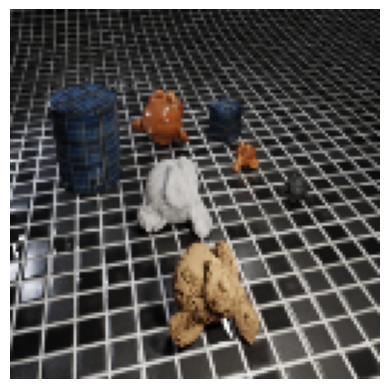

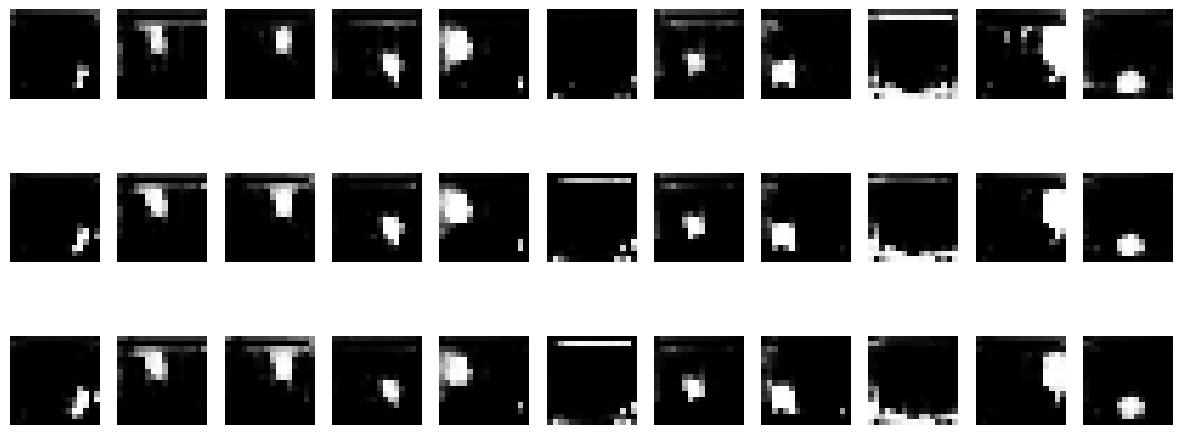

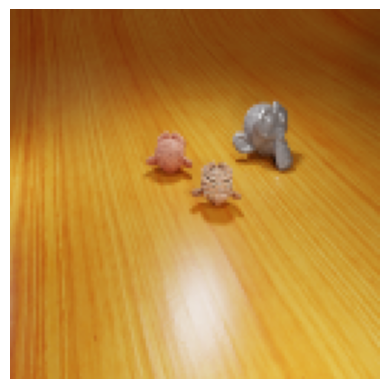

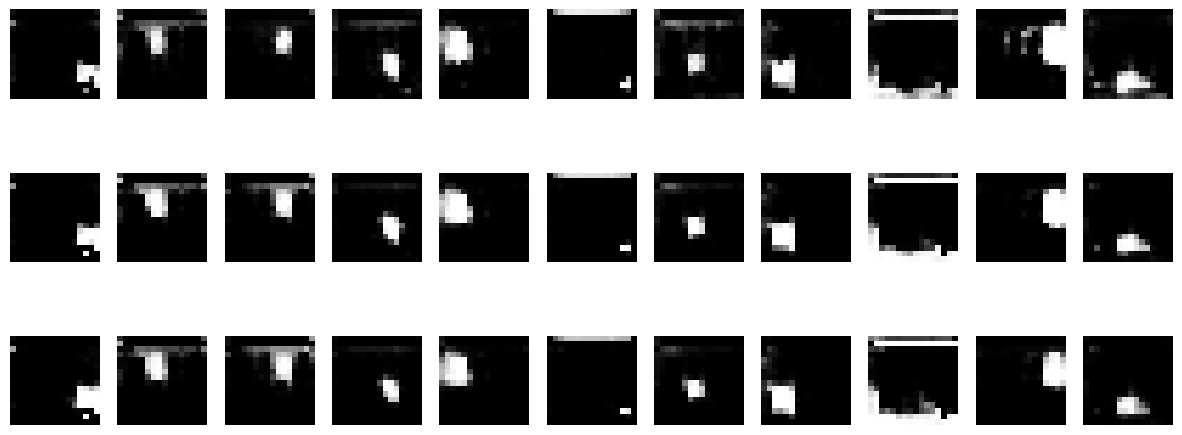

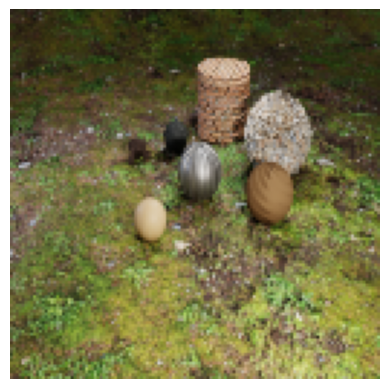

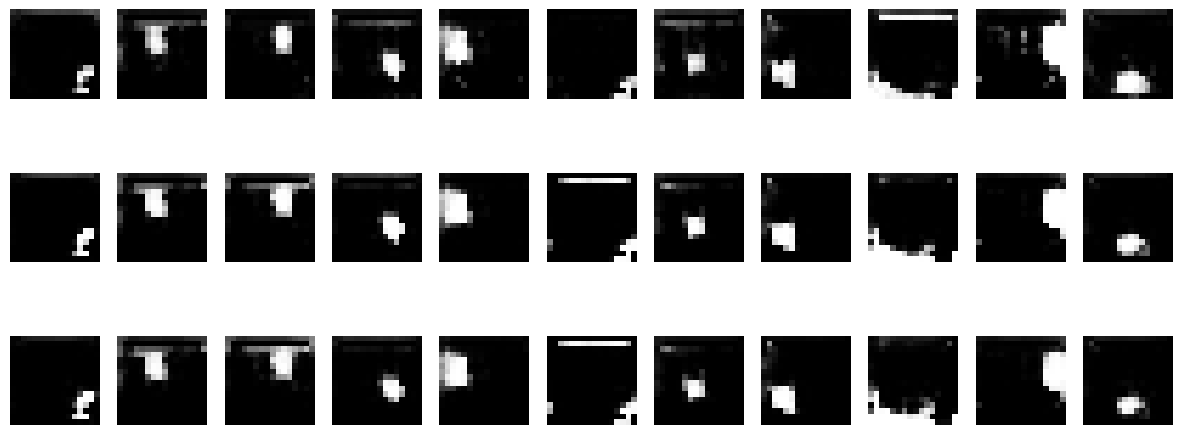

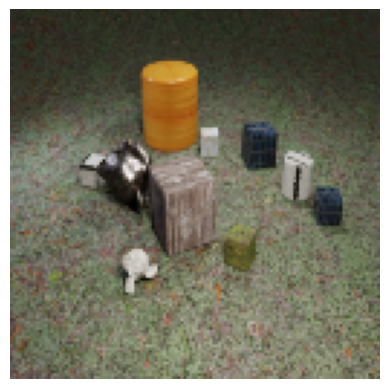

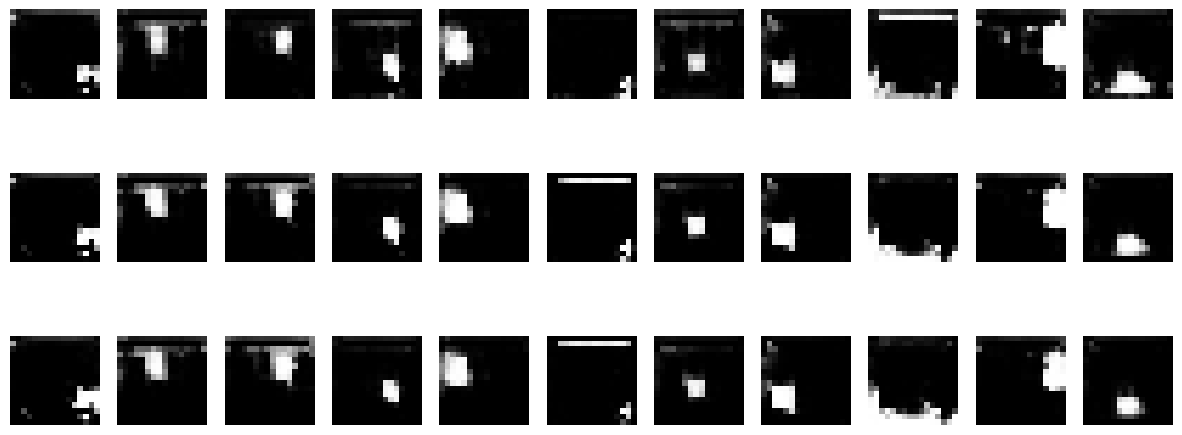

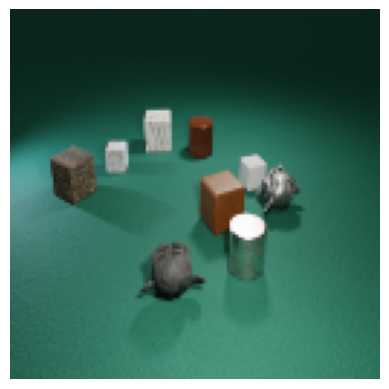

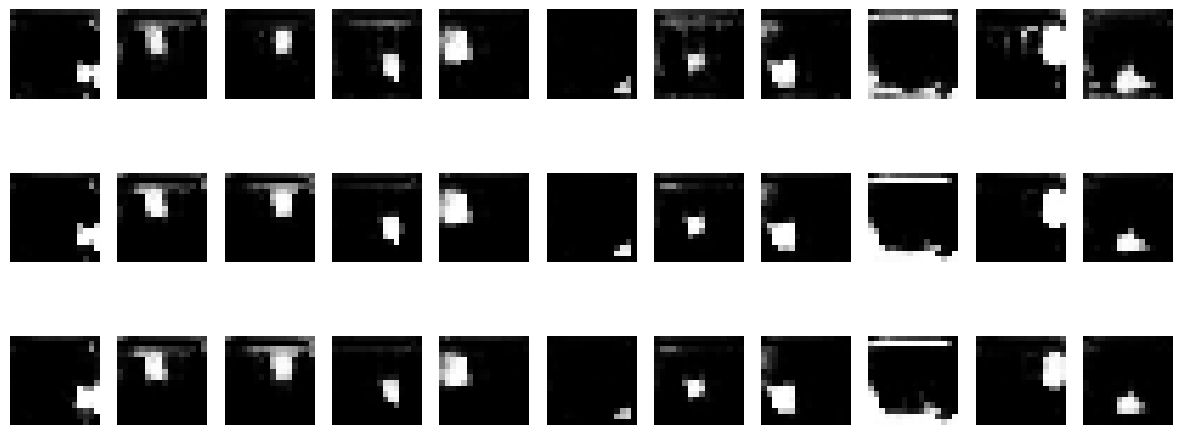

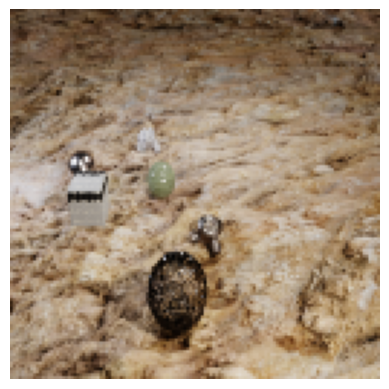

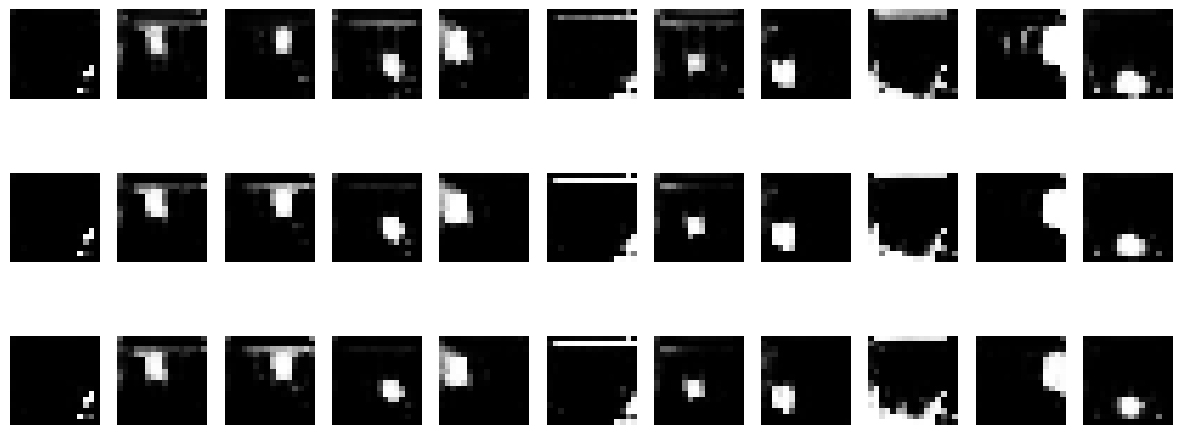

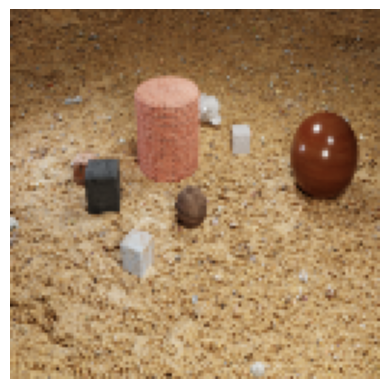

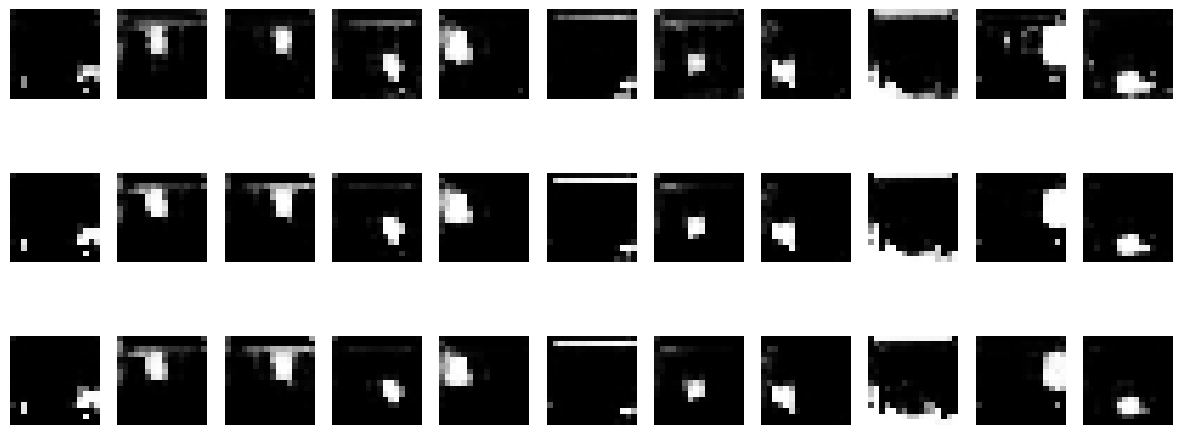

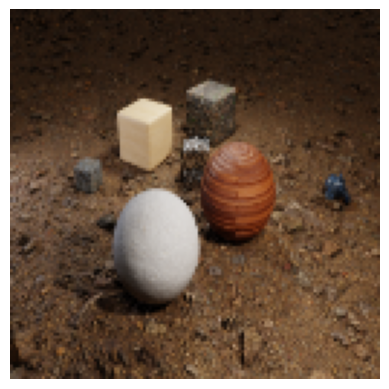

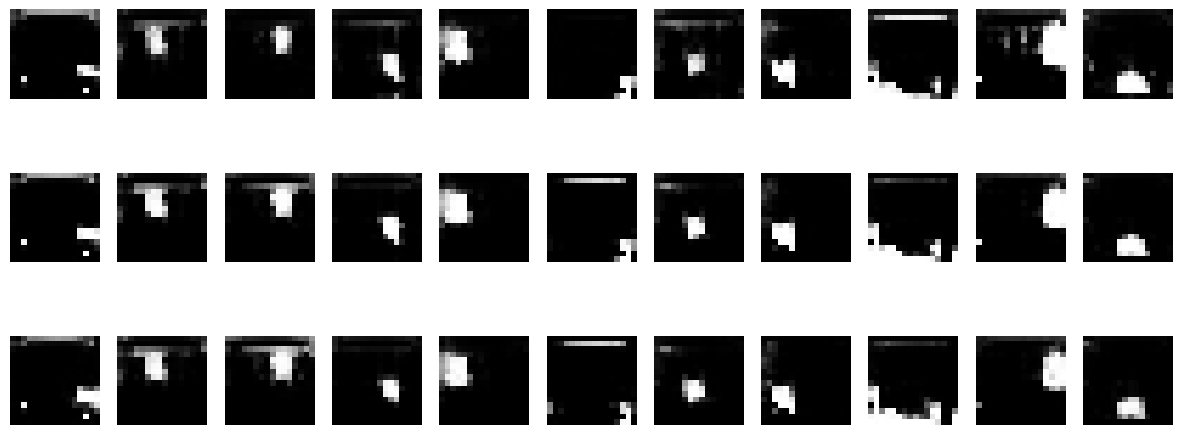

In [12]:
model_diff = SlotDiffusion(param).to(device)
learner_diff = LearnModelDiff(model_diff, addr.slot_diffusion)
# learner_diff.param.create_report(learner_diff.model_addr)
# learner_diff.model.encoder.load_state_dict(learner.model.encoder.state_dict(), strict=False)        # Pretrained weights from previous part
# learner_diff.model.slot_attention.load_state_dict(learner.model.slot_attention.state_dict(), strict=False)
# learner_diff.train()
# learner_diff.plot_loss()
learner_diff.best_model()
# learner_diff.model.load_state_dict(torch.load(addr.diff_checkpoint), strict=False)
# learner_diff.ARI_score(total=True)
# learner_diff.slot_lib(show_ct=4)
# learner_diff.visualize()
learner_diff.attn_map()